In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('user_artists.dat', sep="\t", skiprows=1, names=['userID','artistID', 'weight'])


In [3]:
user_ids = data["userID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
artist_ids = data["artistID"].unique().tolist()
artist2artist_encoded = {x: i for i, x in enumerate(artist_ids)}
artist_encoded2artist = {i: x for i, x in enumerate(artist_ids)}
data["user"] = data["userID"].map(user2user_encoded)
data["artist"] = data["artistID"].map(artist2artist_encoded)

num_users = len(user2user_encoded)
num_artists = len(artist_encoded2artist)
data["weight"] = data["weight"].values.astype(np.float32)

min_rating = min(data["weight"])
max_rating = max(data["weight"])

print(
    "Number of users: {}, Number of artists: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_artists, min_rating, max_rating
    )
)

Number of users: 1892, Number of artists: 17632, Min rating: 1.0, Max rating: 352698.0


In [4]:
data = data.sample(frac=1, random_state=42)
x = data[["user", "artist"]].values
y = data["weight"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * data.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [5]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_artists, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_artists = num_artists
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.artist_embedding = layers.Embedding(
            num_artists,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.artist_bias = layers.Embedding(num_artists, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        artist_vector = self.artist_embedding(inputs[:, 1])
        artist_bias = self.artist_bias(inputs[:, 1])
        dot_user_artist = tf.tensordot(user_vector, artist_vector, 2)
        x = dot_user_artist + user_bias + artist_bias
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_artists, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()], optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/30
1306/1306 [==============================] - 16s 11ms/step - loss: 0.2679 - sparse_categorical_accuracy: 0.0069 - val_loss: 0.0213 - val_sparse_categorical_accuracy: 0.0067
Epoch 2/30
1306/1306 [==============================] - 14s 11ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.0069 - val_loss: 0.0188 - val_sparse_categorical_accuracy: 0.0067
Epoch 3/30
1306/1306 [==============================] - 14s 11ms/step - loss: 0.0165 - sparse_categorical_accuracy: 0.0069 - val_loss: 0.0183 - val_sparse_categorical_accuracy: 0.0067
Epoch 4/30
1306/1306 [==============================] - 14s 11ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.0069 - val_loss: 0.0178 - val_sparse_categorical_accuracy: 0.0067
Epoch 5/30
1306/1306 [==============================] - 14s 11ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.0069 - val_loss: 0.0171 - val_sparse_categorical_accuracy: 0.0067
Epoch 6/30
1306/1306 [==============================] - 14s 11ms/step - loss: 0.

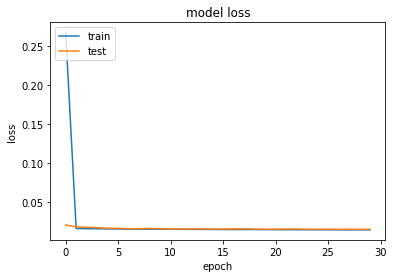

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [13]:
artist_df = pd.read_csv('artistsWithGenreNew2.dat', sep='\t', skiprows=1, names=['id','name', 'url', 'pictureURL', 'genre'])
user_id = 785
artists_watched_by_user = data[data.userID == user_id]
artists_not_watched = artist_df[
    ~artist_df["id"].isin(artists_watched_by_user.artistID.values)
]["id"]
artists_not_watched = list(
    set(artists_not_watched).intersection(set(artist2artist_encoded.keys()))
)
artists_not_watched = [[artist2artist_encoded.get(x)] for x in artists_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_artist_array = np.hstack(
    ([[user_encoder]] * len(artists_not_watched), artists_not_watched)
)
ratings = model.predict(user_artist_array).flatten()
top_ratings_indices = ratings.argsort()[-12:][::-1]
recommended_artist_ids = [
    artist_encoded2artist.get(artists_not_watched[x][0]) for x in top_ratings_indices
]

print("Enseñando recomendaciones del usuario: {}".format(user_id))
print("====" * 9)
print("Artistas con alta valoración del usuario")
print("----" * 8)
top_artists_user = (
    artists_watched_by_user.sort_values(by="weight", ascending=False)
    .head(5)
    .artistID.values
)
artist_df_rows = artist_df[artist_df["id"].isin(top_artists_user)]
for row in artist_df_rows.itertuples():
    print(row.name, ":", row.genre)

print("----" * 8)
print("Top 10 artistas recomendados")
print("----" * 8)
recommended_artists = artist_df[artist_df["id"].isin(recommended_artist_ids)]
for row in recommended_artists.itertuples():
    print(row.name, ":", row.genre)

Enseñando recomendaciones del usuario: 785
Artistas con alta valoración del usuario
--------------------------------
Cher : pop
David Bowie : rock
Pato Fu : rock
Rita Lee : rock
Ludov : rock
--------------------------------
Top 10 artistas recomendados
--------------------------------
Sarah Brightman : soundtracks
Ezginin GÃ¼nlÃ¼ÄŸÃ¼ : folk
DICKY DIXON LAKE RECORDS : other
Viking Quest : pop
Luzmelt : other
Phillip Boa & The Voodooclub : indie
Iron Jesus : electronic
Brooke Fraser : folk
Dicky Dixon : other
RICHARD DIXON-COMPOSER : gospel
80kidz : electronic
Gay Fairy Tales : pop
